In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os

# Canny Edge Detection -- Manually Computed

![title](edge_de.jpg)

# Read Image

[[ 28  39  32  87 199]
 [ 30  39  32  89 202]
 [ 32  39  32  93 206]
 [ 32  40  34  94 206]
 [ 28  40  35  92 202]]


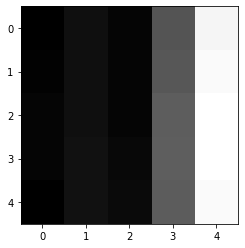

In [2]:
img = mpimg.imread('image_patch/e4.jpg')
print(img)
plt.imshow(img, 'gray')

## Functions to compute each steps defined below sequentially

In [3]:
def convolve(img, kernel):

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    # Do convolution
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            roi = img[i - pad_height:i + pad_height +
                      1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (roi*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

In [4]:
def gaussian_kernel(size, sigma=0.5):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

g = gaussian_kernel(3)

In [5]:
# from scipy.ndimage.filters import convolve
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255 
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [6]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [7]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [8]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

# Step1: Output after applying Gaussian Kernel

[[ 24.22493853  34.08065179  35.47714976  85.6846606  152.62449028]
 [ 28.53763541  38.33601967  39.92230447  97.79679216 173.25762753]
 [ 29.99484928  38.64113141  40.48588756 101.00467156 176.44218674]
 [ 29.90869217  39.43840532  42.04091865 101.9975799  176.55166405]
 [ 24.49506998  35.10854043  38.1462266   89.88544834 155.36806414]]


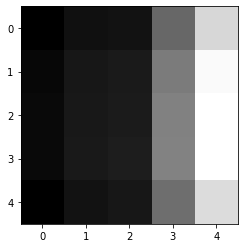

In [9]:
smoothed_img = convolve(img, gaussian_kernel(3))
print(smoothed_img)
plt.imshow(smoothed_img, 'gray')

# Step2: Sobel Operation to Compute Gradient and Slope

In [10]:
grad, slope = sobel_filters(smoothed_img)
print('---------Gradients------------------\n',grad)
print('\n------------------Slope----------------\n', slope)

---------Gradients------------------
 [[ 64.9949999   67.74511062 122.90429673 249.90093865 236.1340412 ]
 [ 68.30093148  22.16329718 106.72968973 237.80725169 176.10919083]
 [ 70.50345571  20.3921768  112.24390427 245.43034896 182.70772159]
 [ 69.69089828  23.022892   110.46997801 238.27380823 181.12280929]
 [ 67.2311872   70.86349709 128.9536358  255.         243.30810674]]

------------------Slope----------------
 [[-0.73054705 -1.34140128 -0.92526632 -0.83834108 -2.11547271]
 [-0.10735651 -0.42040278 -0.12768018 -0.11391294 -2.97837489]
 [-0.02478907 -0.12727621 -0.03864546 -0.02558775 -3.11474803]
 [ 0.09492764  0.29869271  0.07962668  0.08720124  3.00750849]
 [ 0.73565878  1.31506453  0.9189068   0.85305276  2.12516632]]


# Step3: Non-Maximum Supression

[[  0   0   0   0   0]
 [  0   0   0 237   0]
 [  0   0   0 245   0]
 [  0   0   0 238   0]
 [  0   0   0   0   0]]


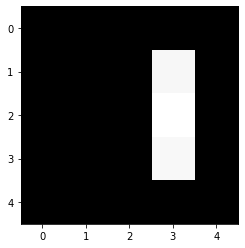

In [11]:
non_max_img = non_max_suppression(grad, slope)
print(non_max_img)
plt.imshow(non_max_img, 'gray')

# Step4: Double Thresholding

[[  0   0   0   0   0]
 [  0   0   0 255   0]
 [  0   0   0 255   0]
 [  0   0   0 255   0]
 [  0   0   0   0   0]]


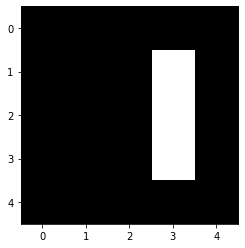

In [12]:
thres_img, weak, strong = threshold(non_max_img) 
print(thres_img)
plt.imshow(thres_img, 'gray')

# Step 5: Final Output with Hysterisis

[[  0   0   0   0   0]
 [  0   0   0 255   0]
 [  0   0   0 255   0]
 [  0   0   0 255   0]
 [  0   0   0   0   0]]


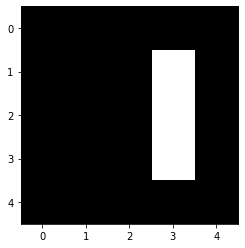

In [13]:
final_image = hysteresis(thres_img, weak)
print(final_image)
plt.imshow(final_image, 'gray')